**IMAGE COMPRESSION WITH USING TRUNCATED SINGULAR VALUE DECOMPOSITION**
-----------------------------------------------------------------------------------------------

 **Lecture:** Numerical Methods for Computer Engineering   
 **CRN:** 22592  
 **Student Name:** İlke Başak Baydar  
 **Student ID:** 150140709  

Image 1 loaded successfully. Shape: (462, 640, 3)


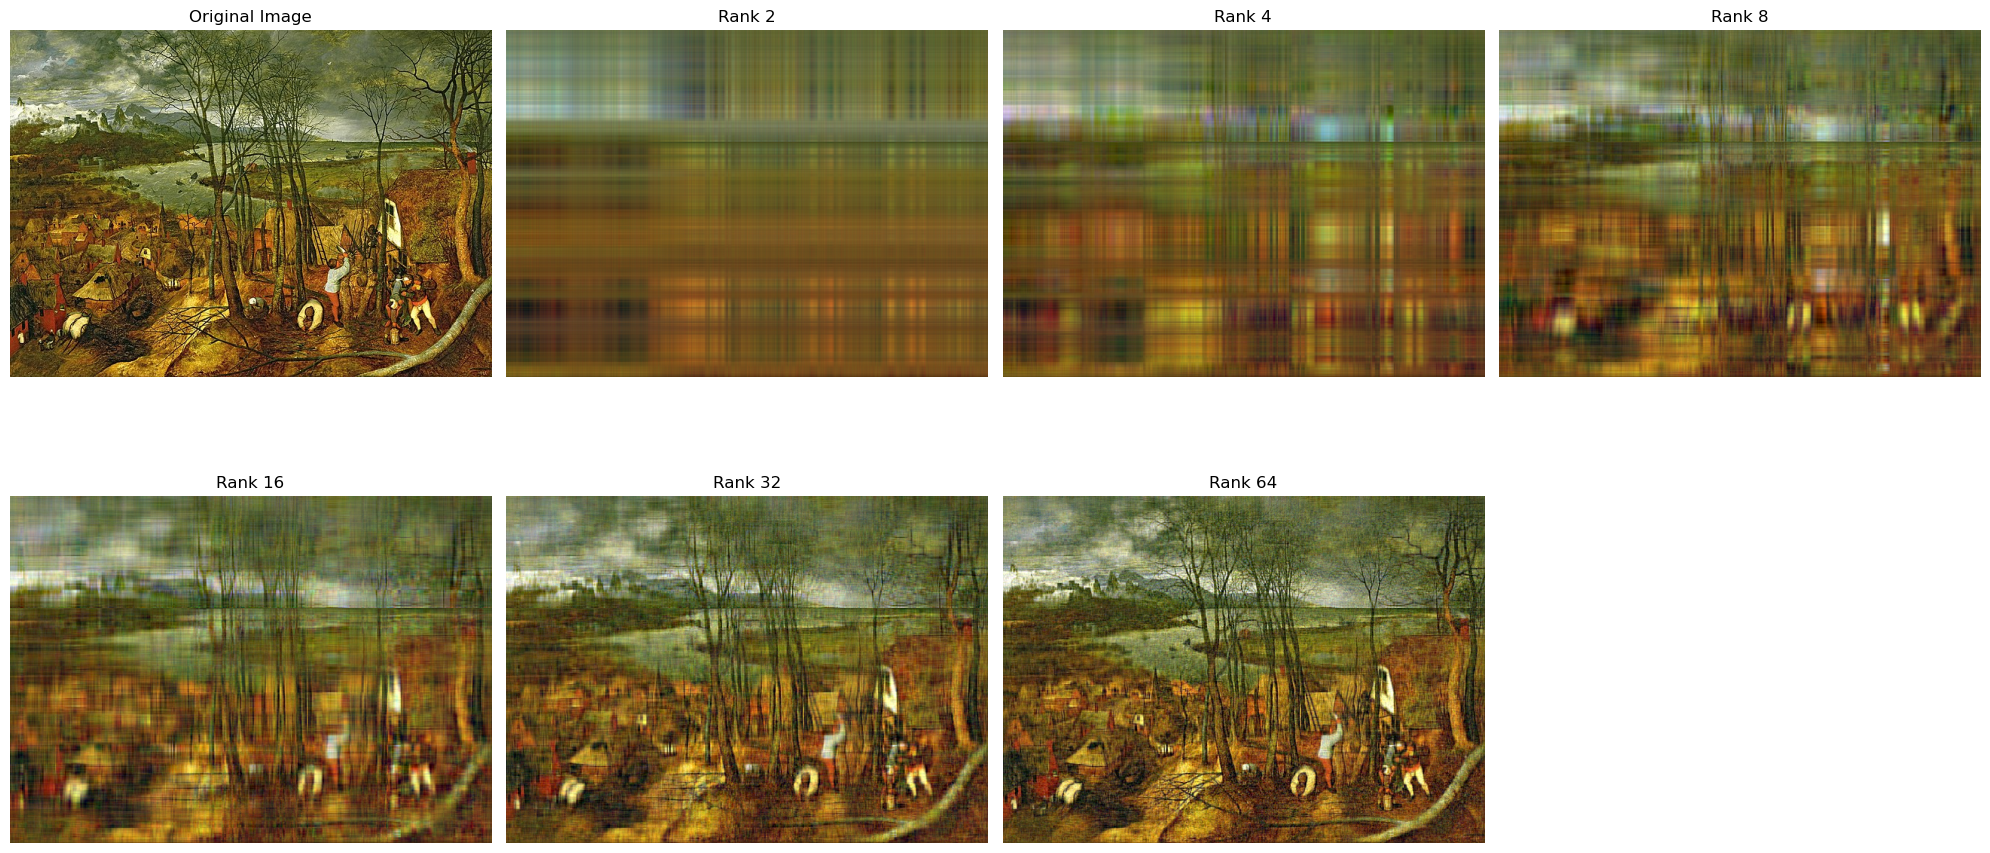

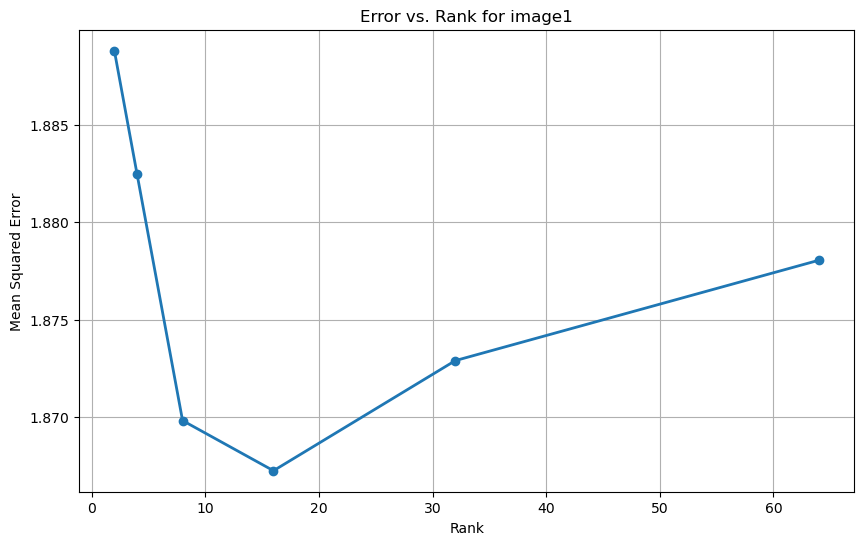

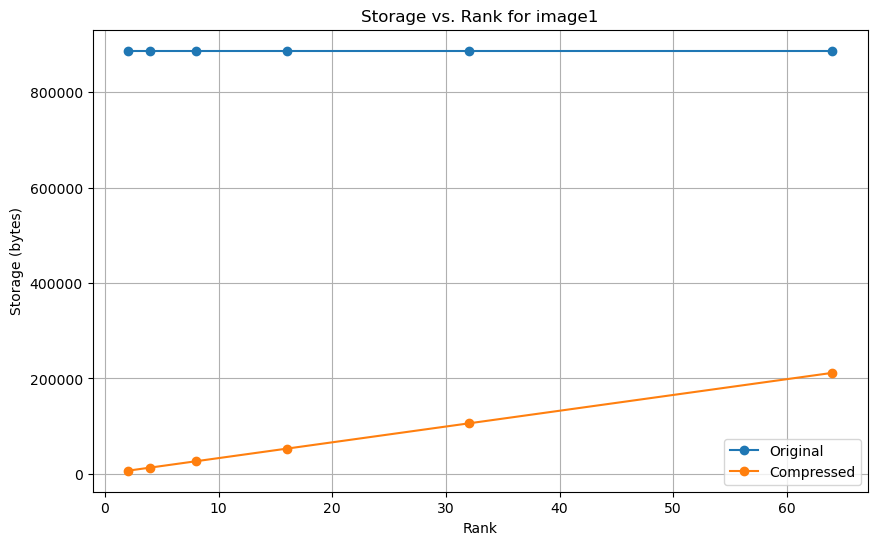

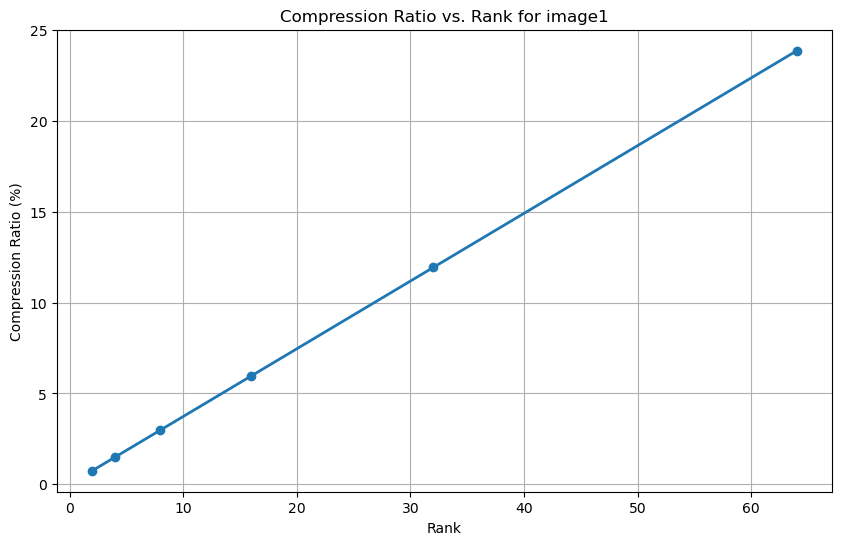


Results for Image 1:
Rank       Error           Compression Ratio    Original Size (KB)   Compressed Size (KB) Time (s)  
-----------------------------------------------------------------------------------------------
2          1.8888          0.7461               866.25               6.46                 1.97      
4          1.8825          1.4922               866.25               12.93                2.08      
8          1.8698          2.9843               866.25               25.85                2.35      
16         1.8672          5.9686               866.25               51.70                2.89      
32         1.8729          11.9372              866.25               103.41               4.19      
64         1.8781          23.8745              866.25               206.81               5.63      
Image 2 loaded successfully. Shape: (512, 512, 3)


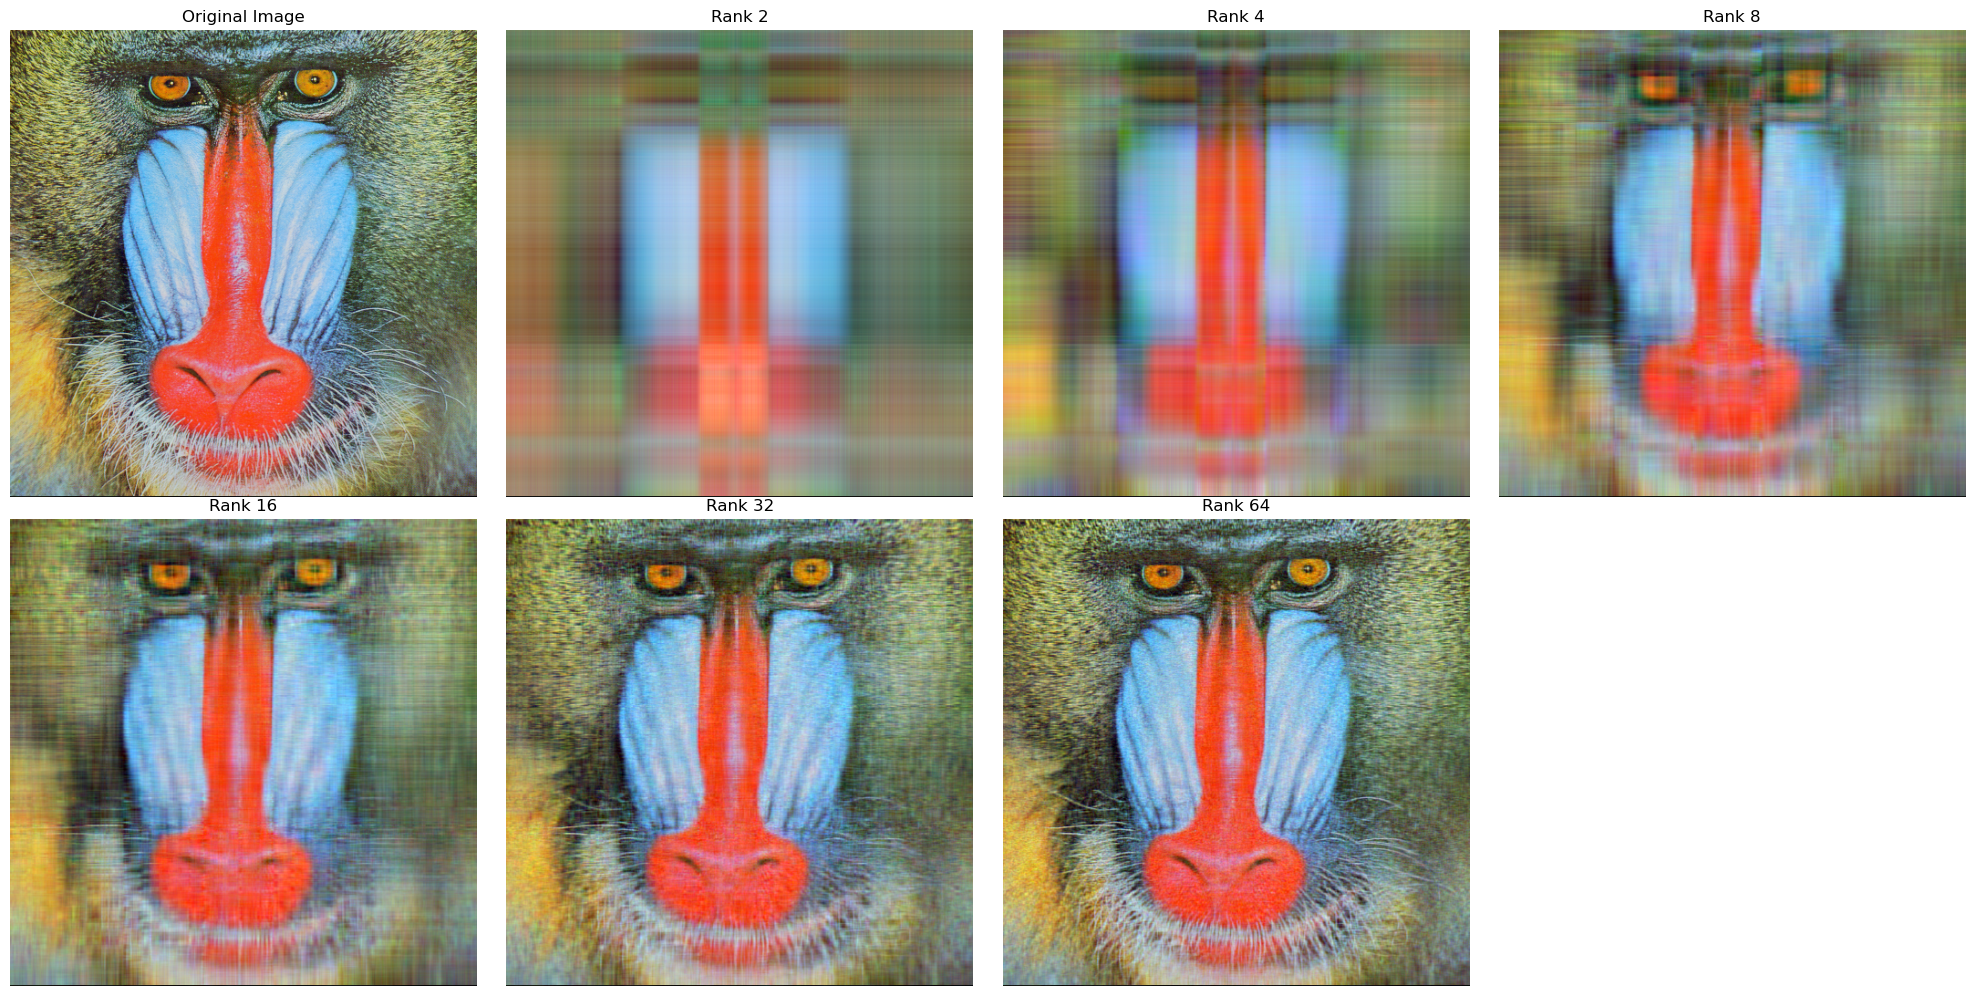

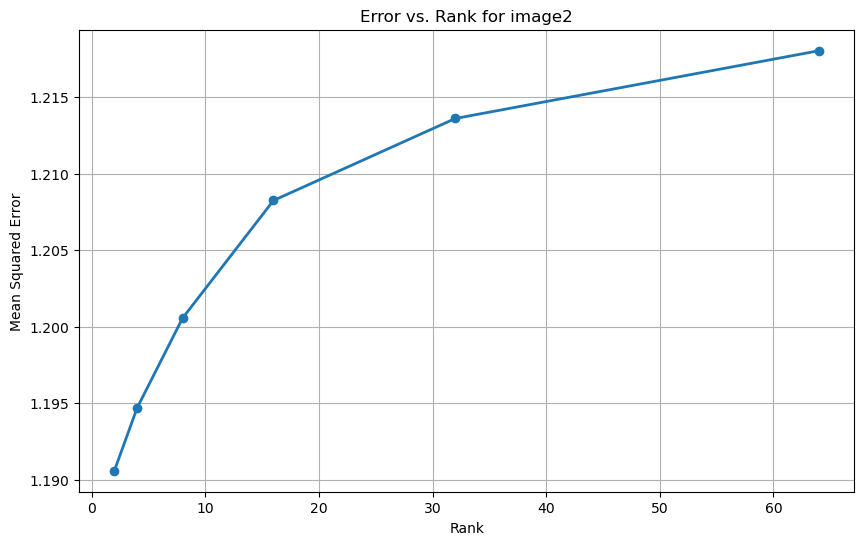

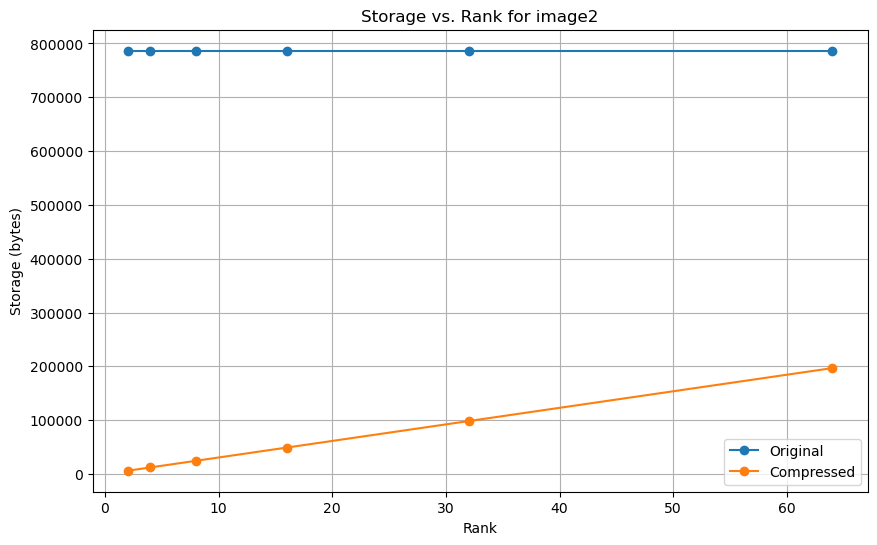

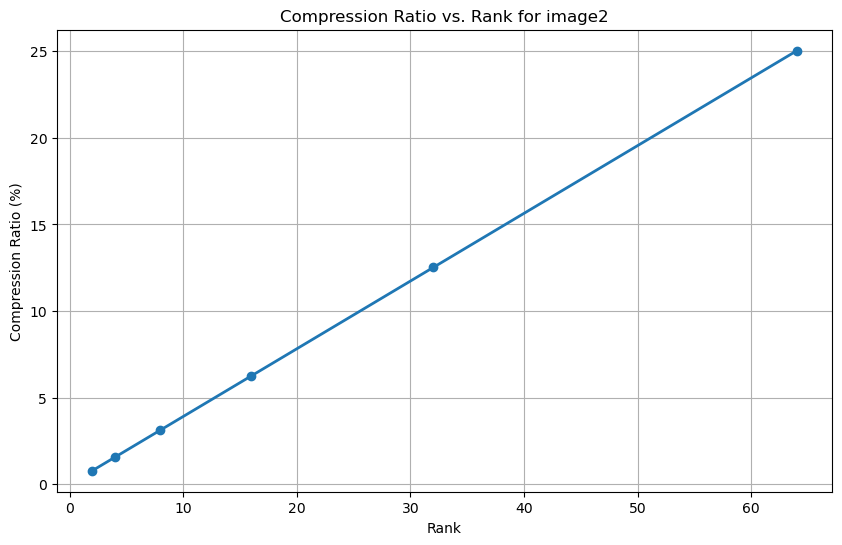


Results for Image 2:
Rank       Error           Compression Ratio    Original Size (KB)   Compressed Size (KB) Time (s)  
-----------------------------------------------------------------------------------------------
2          1.1906          0.7820               768.00               6.01                 1.57      
4          1.1947          1.5640               768.00               12.01                1.71      
8          1.2006          3.1281               768.00               24.02                1.78      
16         1.2082          6.2561               768.00               48.05                2.15      
32         1.2136          12.5122              768.00               96.09                2.87      
64         1.2180          25.0244              768.00               192.19               4.57      


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

# Power iteration method to find the largest eigenvalue and eigenvector
def power_iteration(A, num_iterations=100, tol=1e-10):
    n = A.shape[0]
    b_k = np.random.rand(n)
    for _ in range(num_iterations):
        b_k1 = A @ b_k
        b_k1_norm = np.linalg.norm(b_k1)
        if b_k1_norm < tol:
            return 0, b_k
        b_k = b_k1 / b_k1_norm
        eigenvalue = (b_k @ A @ b_k) / (b_k @ b_k)
    return eigenvalue, b_k

# Implementation of Truncated SVD from scratch
def my_svd(A, rank):
    m, n = A.shape
    ATA = A.T @ A
    sigma = np.zeros(rank)
    U = np.zeros((m, rank))
    V = np.zeros((n, rank))
    ATA_temp = ATA.copy()
    A_temp = A.copy()
    for i in range(rank):
        eigenvalue, eigenvector = power_iteration(ATA_temp)
        if eigenvalue <= 0:
            break
        sigma[i] = np.sqrt(eigenvalue)
        V[:, i] = eigenvector
        if sigma[i] > 1e-10:
            U[:, i] = A_temp @ V[:, i] / sigma[i]
        else:
            U[:, i] = np.zeros(m)
        outer_product = sigma[i] * np.outer(U[:, i], V[:, i])
        A_temp = A_temp - outer_product
        ATA_temp = A_temp.T @ A_temp
    return U, sigma, V

def tsvd_channel(channel, rank):
    U, sigma, V = my_svd(channel, rank)
    compressed_channel = np.zeros_like(channel, dtype=float)
    for i in range(rank):
        compressed_channel += sigma[i] * np.outer(U[:, i], V[:, i])
    compressed_channel = np.clip(compressed_channel, 0, 255).astype(np.uint8)
    return compressed_channel, U, sigma, V

def calculate_error(original, compressed):
    return np.linalg.norm(original - compressed) / np.linalg.norm(original)

def calculate_storage(original_shape, rank):
    m, n = original_shape
    original_storage = m * n
    compressed_storage = m * rank + rank + n * rank
    return original_storage, compressed_storage

def compress_rgb_image(image, ranks):
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]
    m, n = red_channel.shape
    original_storage = m * n
    results = {}
    for r in ranks:
        start_time = time.time()
        red, U_r, s_r, V_r = tsvd_channel(red_channel, r)
        green, U_g, s_g, V_g = tsvd_channel(green_channel, r)
        blue, U_b, s_b, V_b = tsvd_channel(blue_channel, r)
        reconstructed = np.stack([red, green, blue], axis=2)
        error = (calculate_error(red_channel, red) +
                 calculate_error(green_channel, green) +
                 calculate_error(blue_channel, blue)) / 3
        _, comp_storage = calculate_storage((m, n), r)
        comp_storage *= 3
        compression_ratio = comp_storage / (original_storage * 3) * 100
        exec_time = time.time() - start_time
        results[r] = {
            'reconstructed': reconstructed,
            'error': error,
            'compression_ratio': compression_ratio,
            'storage_original': original_storage * 3,
            'storage_compressed': comp_storage,
            'execution_time': exec_time
        }
    return results

def plot_reconstructed_images(original_image, results, ranks, image_name):
    n_ranks = len(ranks)
    n_rows = (n_ranks + 2) // 4
    n_cols = 4
    plt.figure(figsize=(20, 5 * n_rows))
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    for i, r in enumerate(ranks):
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(results[r]['reconstructed'])
        plt.title(f'Rank {r}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{image_name}_reconstructed.png', dpi=300)
    plt.show()

def plot_error_vs_rank(results, ranks, image_name):
    errors = [results[r]['error'] for r in ranks]
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, errors, 'o-', linewidth=2)
    plt.title(f'Error vs. Rank for {image_name}')
    plt.xlabel('Rank')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.savefig(f'{image_name}_error_plot.png', dpi=300)
    plt.show()

def plot_storage_vs_rank(results, ranks, image_name):
    original = [results[r]['storage_original'] for r in ranks]
    compressed = [results[r]['storage_compressed'] for r in ranks]
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, original, 'o-', label='Original')
    plt.plot(ranks, compressed, 'o-', label='Compressed')
    plt.title(f'Storage vs. Rank for {image_name}')
    plt.xlabel('Rank')
    plt.ylabel('Storage (bytes)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{image_name}_storage_plot.png', dpi=300)
    plt.show()

def plot_compression_ratio_vs_rank(results, ranks, image_name):
    ratios = [results[r]['compression_ratio'] for r in ranks]
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, ratios, 'o-', linewidth=2)
    plt.title(f'Compression Ratio vs. Rank for {image_name}')
    plt.xlabel('Rank')
    plt.ylabel('Compression Ratio (%)')
    plt.grid(True)
    plt.savefig(f'{image_name}_compression_ratio_plot.png', dpi=300)
    plt.show()

def print_results_table(results, ranks):
    print(f"{'Rank':<10} {'Error':<15} {'Compression Ratio':<20} {'Original Size (KB)':<20} {'Compressed Size (KB)':<20} {'Time (s)':<10}")
    print("-" * 95)
    for r in ranks:
        print(f"{r:<10} {results[r]['error']:<15.4f} {results[r]['compression_ratio']:<20.4f} "
              f"{results[r]['storage_original'] / 1024:<20.2f} {results[r]['storage_compressed'] / 1024:<20.2f} "
              f"{results[r]['execution_time']:<10.2f}")

# Main execution
if __name__ == "__main__":
    ranks = [2, 4, 8, 16, 32, 64]
    try:
        image1 = Image.open("brueghel.png")
        image1_array = np.array(image1)
        print(f"Image 1 loaded successfully. Shape: {image1_array.shape}")
        results1 = compress_rgb_image(image1_array, ranks)
        plot_reconstructed_images(image1_array, results1, ranks, 'image1')
        plot_error_vs_rank(results1, ranks, 'image1')
        plot_storage_vs_rank(results1, ranks, 'image1')
        plot_compression_ratio_vs_rank(results1, ranks, 'image1')
        print("\nResults for Image 1:")
        print_results_table(results1, ranks)
    except Exception as e:
        print(f"Failed to load or process Image 1: {e}")

    try:
        image2 = Image.open("mandrill.png")
        image2_array = np.array(image2)
        print(f"Image 2 loaded successfully. Shape: {image2_array.shape}")
        results2 = compress_rgb_image(image2_array, ranks)
        plot_reconstructed_images(image2_array, results2, ranks, 'image2')
        plot_error_vs_rank(results2, ranks, 'image2')
        plot_storage_vs_rank(results2, ranks, 'image2')
        plot_compression_ratio_vs_rank(results2, ranks, 'image2')
        print("\nResults for Image 2:")
        print_results_table(results2, ranks)
    except Exception as e:
        print(f"Failed to load or process Image 2: {e}")
